Author: Monika Dörig, monika.doerig@balgrist.ch

__Integrative Spinal Research, Department of Chiropractic Medicine, Balgrist University Hospital, University of Zurich, Zurich, Switzerland__

__Lucerne University of Applied Sciences and Arts, Horw__

# Wholebrain searchlight approach in healthy subjects
The current searchlight analysis is implemented for two runs with non smoothed data. It uses the Crossnobis estimator for calculating the  searchlight RDMs.


In [1]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
from nilearn.image import new_img_like
import pandas as pd
import nibabel as nib
from nilearn import plotting
import rsatoolbox as rsa
import rsatoolbox.data as rsd
import rsatoolbox.rdm as rsr
from rsatoolbox.rdm.rdms import RDMs
from glob import glob
from pathlib import Path
import os
from rsatoolbox.inference import eval_fixed
from rsatoolbox.model import ModelFixed
from rsatoolbox.rdm import RDMs
from rsatoolbox.util.searchlight import get_volume_searchlight, get_searchlight_RDMs, evaluate_models_searchlight
from nltools.stats import fdr, threshold, fisher_r_to_z, one_sample_permutation
from pytictoc import TicToc

## Overview
1. Import Models (Simple, Segmental and Random Model)
2. Import Wholebrain Mask and affine
3. Import data for healthy subjects: Data preparation and preprocessing
4. Searchlight approach: spherical searchlight with radius 2, crossnobis distance measure
5. Evaluate Models: evaluates each searchlight with the given models (Kendall's tau-a correlation)
- Subject-level evaluation
- Group-level evaluation
- Group-level Kendall's Tau-a Maps
- Brain RDM of the searchlight with the best model fit (group-level)
- MNI Location of best model fit at group-level


In [2]:
t = TicToc() # create TicToc instance

## 1. Load Models

In [3]:
def upper_tri(RDM):
    """upper_tri returns the upper triangular index of an RDM
    
    Args:
        RDM 2Darray: squareform RDM
    
    Returns:
        1D array: upper triangular vector of the RDM
    """
    # returns the upper triangle
    m = RDM.shape[0]
    r, c = np.triu_indices(m, 1) #Return the indices for the upper-triangle of an (n, m) array
    return RDM[r, c]

In [4]:
import matplotlib.colors
def RDMcolormapObject(direction=1):
    """
    Returns a matplotlib color map object for RSA and brain plotting
    """
    if direction == 0:
        cs = ['yellow', 'red', 'gray', 'turquoise', 'blue']
    elif direction == 1:
        cs = ['blue', 'turquoise', 'gray', 'red', 'yellow']
    else:
        raise ValueError('Direction needs to be 0 or 1')
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", cs)
    return cmap

### Segmental model
The linear model is the closer to 0 wherever both pair-wise comparisons are similar and otherwise 1. Neighboring segments are more similar to each other than non-neighboring segments. 

0 --> Similar

1 --> Dissimilar


In [5]:
linear_model = np.load('linear_model.npy')
linear_modelRDM = ModelFixed('Segmental RDM', upper_tri(linear_model))
pred_linear = linear_modelRDM.predict() # returns a numpy vectorized format
pred_rdm_linear = linear_modelRDM.predict_rdm() # returns a RDMs object

des = {'Segment': (['T3', 'T5', 'T7', 'T9', 'T11', 'L1', 'L3', 'L5', 'S1'])}

pred_rdm_linear.pattern_descriptors = des

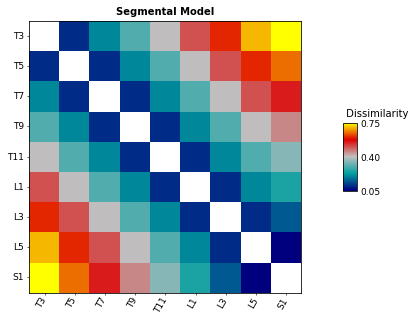

In [6]:
pred_rdm_linear.dissimilarity_measure = " Dissimilarity"
rsa.vis.show_rdm(pred_rdm_linear, show_colorbar ='panel', rdm_descriptor ='Segmental Model', pattern_descriptor ='Segment', figsize=(15,5))
plt.show();
None

### Simple Model
The simple model has a 0 wherever both pair-wise comparisons are similar and otherwise 1 --> differentiatin between upper and lower back

0 --> Similar

1 --> Dissimilar

In [7]:
simple_model = np.load('simple_model.npy')
simple_modelRDM = ModelFixed('Simple RDM', upper_tri(simple_model))
pred = simple_modelRDM.predict() # returns a numpy vectorized format
pred_rdm_simple = simple_modelRDM.predict_rdm() # returns a RDMs object
pred_rdm_simple.pattern_descriptors = des

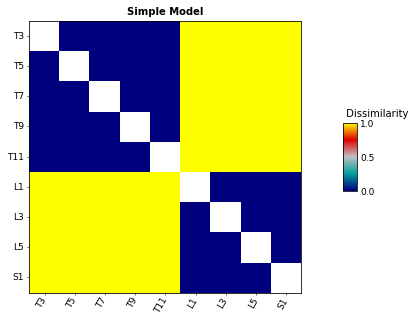

In [8]:
pred_rdm_simple.dissimilarity_measure = " Dissimilarity"
rsa.vis.show_rdm(pred_rdm_simple, show_colorbar = 'panel', rdm_descriptor = 'Simple Model', pattern_descriptor = 'Segment', figsize=(15,5))
plt.show();
None

### Random Model

In [9]:
random_model = np.load('random_model.npy')
random_modelRDM = ModelFixed('Random RDM', upper_tri(random_model))
pred_rdm_random = random_modelRDM.predict_rdm() # returns a RDMs object
pred_rdm_random.pattern_descriptors = des

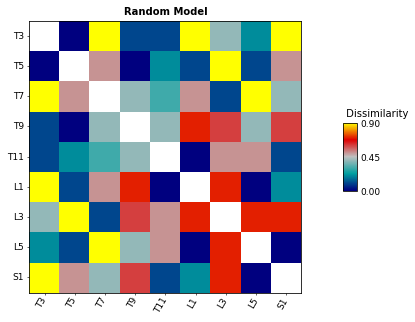

In [10]:
pred_rdm_random.dissimilarity_measure = " Dissimilarity"
rsa.vis.show_rdm(pred_rdm_random, show_colorbar = 'panel', rdm_descriptor = 'Random Model', pattern_descriptor = 'Segment', figsize=(15,5))
plt.show();
None

## 2. Load whole brain mask and affine

In [11]:
# Mask
mask_path = '/mnt/Statistical_contrast_images/FSL_mask_41HC_45PAT.nii.gz' 
mask_img = nib.load(mask_path)
mask_data = mask_img.get_fdata()
x, y, z = mask_img.get_fdata().shape

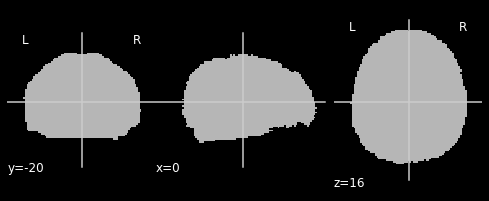

In [12]:
plotting.plot_anat(mask_img)
plt.show();

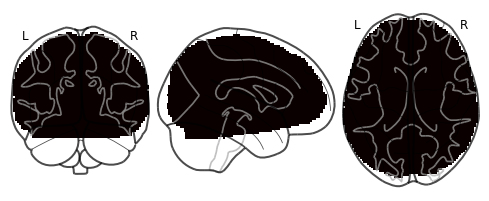

In [13]:
plotting.plot_glass_brain(mask_img)
plt.show();

In [14]:
# Get image for affine
test_path = '/mnt/Statistical_contrast_images/HLC/HC200/run1/cope28.nii.gz'
test_img = nib.load(test_path)
test_data = test_img.get_fdata()
affine = test_img.affine

## 3. Data import and preprocessing

### 3.1. Data import and preparation of lists of the two runs

In [16]:
HC_all = Path('/mnt/Statistical_contrast_images/HLC')
directory_list_HC=list(HC_all.iterdir())
directory_list_HC.sort()
del directory_list_HC[0]

HC_name_list = []
for i in directory_list_HC:
    full_path_HC = os.path.split(i)
    HC_name_list.append(full_path_HC[1])

nSubj = len(directory_list_HC)
print('Number of subjects:', nSubj)
nCond = len(list(glob(f"{directory_list_HC[0]}/cope*.nii.gz")))-2 #ignore copes 46 and 47
print('Number of conditions:', nCond)

Number of subjects: 41
Number of conditions: 18


In [17]:
HC_name_list
#np.save('HC_name_list', HC_name_list)

['HC200',
 'HC201',
 'HC202',
 'HC205',
 'HC206',
 'HC207',
 'HC208',
 'HC209',
 'HC210',
 'HC211',
 'HC212',
 'HC213',
 'HC214',
 'HC215',
 'HC216',
 'HC218',
 'HC220',
 'HC221',
 'HC222',
 'HC223',
 'HC224',
 'HC225',
 'HC226',
 'HC228',
 'HC229',
 'HC231',
 'HC232',
 'HC234',
 'HC236',
 'HC238',
 'HC239',
 'HC240',
 'HC241',
 'HC242',
 'HC244',
 'HC245',
 'HC246',
 'HC250',
 'HC251',
 'HC253',
 'HC255']

In [18]:
directory_list_HC[:2]

[PosixPath('/mnt/Statistical_contrast_images/HLC/HC200'),
 PosixPath('/mnt/Statistical_contrast_images/HLC/HC201')]

### 3.2. Data preparation for the two runs
- Run 1 and Run 2
- copes 28 to 47

In [19]:
runs_list=[]
for i in directory_list_HC:
    runs_list.append([f for f in i.iterdir() if f.is_dir()])

In [20]:
flat_list = [item for sublist in runs_list for item in sublist]
run1 = flat_list[::3]
run2 = flat_list[2::3]
run1

[PosixPath('/mnt/Statistical_contrast_images/HLC/HC200/run1'),
 PosixPath('/mnt/Statistical_contrast_images/HLC/HC201/run1'),
 PosixPath('/mnt/Statistical_contrast_images/HLC/HC202/run1'),
 PosixPath('/mnt/Statistical_contrast_images/HLC/HC205/run1'),
 PosixPath('/mnt/Statistical_contrast_images/HLC/HC206/run1'),
 PosixPath('/mnt/Statistical_contrast_images/HLC/HC207/run1'),
 PosixPath('/mnt/Statistical_contrast_images/HLC/HC208/run1'),
 PosixPath('/mnt/Statistical_contrast_images/HLC/HC209/run1'),
 PosixPath('/mnt/Statistical_contrast_images/HLC/HC210/run1'),
 PosixPath('/mnt/Statistical_contrast_images/HLC/HC211/run1'),
 PosixPath('/mnt/Statistical_contrast_images/HLC/HC212/run1'),
 PosixPath('/mnt/Statistical_contrast_images/HLC/HC213/run1'),
 PosixPath('/mnt/Statistical_contrast_images/HLC/HC214/run1'),
 PosixPath('/mnt/Statistical_contrast_images/HLC/HC215/run1'),
 PosixPath('/mnt/Statistical_contrast_images/HLC/HC216/run1'),
 PosixPath('/mnt/Statistical_contrast_images/HLC/HC218/

In [21]:
def get_img_list_runs(directory_list, nSubj):
    
    img_path_list = []
    
    for i in np.arange(nSubj):
        img_path = list(glob(f"{directory_list[i]}/*.nii.gz"))
        img_path.sort()
        img_path = img_path[:-3] ##ignore copes 46 and 47, mTS
        img_path_list.append(img_path)
    
    return img_path_list 

In [22]:
img_path_run1 = get_img_list_runs(run1, nSubj)
img_path_run2 = get_img_list_runs(run2, nSubj)
img_path_run1

#decoding: 
#L1 to S1: combined frequencies 20_80Hz
#copes 28 to 45: cope 28 = T3_20Hz, cope29 = T3_80Hz
# --> 20Hz every second element starting at cope 28
# --> 80Hz every second element starting at cope 29

[['/mnt/Statistical_contrast_images/HLC/HC200/run1/L1.nii.gz',
  '/mnt/Statistical_contrast_images/HLC/HC200/run1/L3.nii.gz',
  '/mnt/Statistical_contrast_images/HLC/HC200/run1/L5.nii.gz',
  '/mnt/Statistical_contrast_images/HLC/HC200/run1/S1.nii.gz',
  '/mnt/Statistical_contrast_images/HLC/HC200/run1/T11.nii.gz',
  '/mnt/Statistical_contrast_images/HLC/HC200/run1/T3.nii.gz',
  '/mnt/Statistical_contrast_images/HLC/HC200/run1/T5.nii.gz',
  '/mnt/Statistical_contrast_images/HLC/HC200/run1/T7.nii.gz',
  '/mnt/Statistical_contrast_images/HLC/HC200/run1/T9.nii.gz',
  '/mnt/Statistical_contrast_images/HLC/HC200/run1/cope28.nii.gz',
  '/mnt/Statistical_contrast_images/HLC/HC200/run1/cope29.nii.gz',
  '/mnt/Statistical_contrast_images/HLC/HC200/run1/cope30.nii.gz',
  '/mnt/Statistical_contrast_images/HLC/HC200/run1/cope31.nii.gz',
  '/mnt/Statistical_contrast_images/HLC/HC200/run1/cope32.nii.gz',
  '/mnt/Statistical_contrast_images/HLC/HC200/run1/cope33.nii.gz',
  '/mnt/Statistical_contrast_i

### 3.3. Preprocessing - organize data into sessions of 20Hz and 80Hz with ordered conditions

In [23]:
#20Hz, 80Hz
def get_group_data_array(img_path_list):
 
    """Preprocessing function

    Args:
        directory list of images

    Returns:
        preprocessed neural data (shape: number of observations x number of voxels) 
        data divided into sessions of 20Hz, 80Hz of all subjects 
        with ordered conditions (T3,T5,T7,T9,T11,L1,L3,L5,S1)
    """
    
    #initialize arrays
    group_data_20Hz = np.empty((int(nCond/2), nVox, nSubj))
    group_data_80Hz = np.empty((int(nCond/2), nVox, nSubj))
    
    for nb, i in enumerate(img_path_list):             #nb = index of subject
        data = np.zeros((len(i), x, y, z))             # 27 cond,x,y,z
    
        for ind, im in enumerate(i):                   #ind = index for every cope over all subjects
            data[ind] = nib.load(im).get_fdata()
            
        single_freq = data[9:]           # get copes 28 to 45
        data_20Hz = single_freq[::2]     # get 20 Hz conditions (every second element starting at index 0)
        data_80Hz = single_freq[1::2]    # get 80 Hz conditions (every second element starting at index 1)
        
        # reshape data so we have n_observastions x n_voxels       
        data_20Hz_2d  = data_20Hz.reshape([data_20Hz.shape[0], -1])
        data_20Hz_2d = np.nan_to_num(data_20Hz_2d)
        
        data_80Hz_2d  = data_80Hz.reshape([data_80Hz.shape[0], -1])
        data_80Hz_2d = np.nan_to_num(data_80Hz_2d)
          
        #fill group arrays           
        group_data_20Hz[:,:,nb] = data_20Hz_2d        
        group_data_80Hz[:,:,nb] = data_80Hz_2d

    return group_data_20Hz, group_data_80Hz

#### Stack conditions for each of the two runs (needed for Crossnobis measure)

In [24]:
nVox = x*y*z

HC_run1_20Hz, HC_run1_80Hz = get_group_data_array(img_path_run1)
HC_run2_20Hz, HC_run2_80Hz = get_group_data_array(img_path_run2)


assert  HC_run1_20Hz.shape == HC_run2_20Hz.shape 

In [25]:
def stack_conditions(run1, run2):

    """Function to stack the conditions of the two independent runs for the crossnobis method: run1_cond0, run2_cond0, run1_cond1, run2_cond1...

    Args:
        Neural data of run 1 and run 2 of shape number of conditions, number of voxels, number of subjects

    Returns:
        Neural data with stacked conditions of all subjects:  run1_cond0, run2_cond0, run1_cond1, run2_cond1...
    """  
    
    stacked_runs = np.empty((int(nCond), nVox, nSubj))
    
    #for every subject..
    for nS in range(0, nSubj):
        stacked_conds = []
        
        #stack every condition of the both runs
        for nC in range (0, 9):
            cond_1 = run1[nC,:,nS]
            cond_2 = run2[nC,:,nS]
            stack = np.vstack((cond_1, cond_2))
            stacked_conds.append(stack)
        
        stacked_conds = np.array(stacked_conds).reshape(nCond, nVox)    
        
        stacked_runs[:,:,nS] = stacked_conds
        
    return stacked_runs

In [26]:
stacked_conds_20Hz = stack_conditions(HC_run1_20Hz, HC_run2_20Hz)
stacked_conds_80Hz = stack_conditions(HC_run1_80Hz, HC_run2_80Hz)

In [27]:
stacked_conds_20Hz.shape

(18, 902629, 41)

In [28]:
#need to create dataset with multiple (n_rep) measurements for each pattern
n_rep = 2
conds = np.array(['cond_%02d' % x for x in np.arange(nCond/2)])
conds = np.repeat(conds, n_rep) #marks which measurement comes from which run
sessions = np.tile(np.arange(n_rep), 9)

# 4. Searchlight approach
Search for areas that reflect the similarity patterns according to a model RDM
--> looking for brain regions that code for differential sensory input based on the different segments

###  4.1. Get searchlight centers and neighbors

Searches through the non-zero voxels of the mask, selects centers where proportion of sphere voxels >= self.threshold.


In [29]:
mask_data.shape

(91, 109, 91)

In [30]:
centers, neighbors = get_volume_searchlight(mask_data, radius=2, threshold=1) #mask_data, threshold 1 = 100% of voxels inside brain mask
#155815 searchlights

Finding searchlights...: 100%|████████████████████████████████████████████████| 180189/180189 [00:20<00:00, 8952.98it/s]


Found 155815 searchlights


### 4.2. Get brain RDMs for all searchlights for each healthy subject
- Built-in function: __get_searchlight_RDMs__: Iterates over all the searchlight centers and calculates the RDM

--> customized function to take the noise precision matrix into account: __get_searchlight_RDMs_crossnobis__ --> cross-validated Mahalanobis distance


- __Multivariate noise normalization__: method: 'shrinkage_eye' ('shrinkage_diag' doesn't work):  implements a shrinkage towards a multiple of the diagonal:


Computes an optimal shrinkage estimate of a sample covariance matrix
    as described by the following publication:

    Ledoit and Wolfe (2004): "A well-conditioned
    estimator for large-dimensional covariance matrices"

In [26]:
#needed for customized crossnobis function
from tqdm import tqdm
from rsatoolbox.data.dataset import Dataset
from rsatoolbox.rdm.calc import calc_rdm

In [27]:
def get_searchlight_RDMs_crossnobis(data_2d, centers, neighbors, events, sessions,
                         method='crossnobis', verbose=True):
    """Iterates over all the searchlight centers and calculates the RDM

    Args:

        data_2d (2D numpy array): brain data,
        shape n_observations x n_channels (i.e. voxels/vertices)

        centers (1D numpy array): center indices for all searchlights as provided
        by rsatoolbox.util.searchlight.get_volume_searchlight

        neighbors (list): list of lists with neighbor voxel indices for all searchlights
        as provided by rsatoolbox.util.searchlight.get_volume_searchlight

        events (1D numpy array): 1D array of length n_observations

        method (str, optional): distance metric,
        see rsatoolbox.rdm.calc for options.

        verbose (bool, optional): Defaults to True.

    Returns:
        RDM [rsatoolbox.rdm.RDMs]: RDMs object with the RDM for each searchlight
                              the RDM.rdm_descriptors['voxel_index']
                              describes the center voxel index each RDM is associated with
    """

 
    data_2d, centers = np.array(data_2d), np.array(centers)
    n_centers = centers.shape[0]

    # chunking of data for memory reasons
    chunked_center = np.split(np.arange(n_centers),
                              np.linspace(0, n_centers,
                                          101, dtype=int)[1:-1])

    # loop over chunks
    n_conds = len(np.unique(events))

    RDM = np.zeros((n_centers, n_conds * (n_conds - 1) // 2))
    for chunks in tqdm(chunked_center, desc='Calculating RDMs...'):
        center_data = []
        noise_data = []

        for c in chunks:
            # grab this center and neighbors
            center = centers[c]
            center_neighbors = neighbors[c]
            # create a database object with this data
            ds = Dataset(data_2d[:, center_neighbors],
                         descriptors={'center': center},
                         obs_descriptors= {'events': events, 'sessions': sessions},
                         channel_descriptors={'voxels': center_neighbors})
            
            #calculate noise precision --> multivariate noise normalization: shrinkage_eye
            #for univariate noise normalization: diag
            ns = rsd.noise.prec_from_measurements(ds, obs_desc='events', method='shrinkage_eye') 
           
            center_data.append(ds) 
            noise_data.append(ns)

        RDM_corr = calc_rdm(center_data, method=method, noise = noise_data, 
                            descriptor='events', cv_descriptor='sessions') 
        RDM[chunks, :] = RDM_corr.dissimilarities
            
   
    SL_rdms = RDMs(RDM,
                   rdm_descriptors={'voxel_index': centers},
                   dissimilarity_measure=method) 

    return SL_rdms

#### Calculate RDMs for 20 Hz
- convert to numpy arrays to save intermediate results

In [28]:
%%capture
t.tic()
SL_runs_20Hz = []
for i in range (0, nSubj):
    SL_RDM = get_searchlight_RDMs_crossnobis(stacked_conds_20Hz[:,:,i], centers, neighbors, conds, sessions, method='crossnobis')
    SL_runs_20Hz.append(SL_RDM)
t.toc()

Calculating RDMs...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:54<00:00,  4.14s/it]

Elapsed time is 16998.722676 seconds.


In [29]:
SL_matrices_20Hz = []
for sl in SL_runs_20Hz:
    SL_matrices_20Hz.append(sl.get_matrices())
    
SL_runs_20Hz_array = np.array(SL_matrices_20Hz)
np.save('SL_RDMs_20Hz.npy', SL_runs_20Hz_array)

#### Calculate RDMs for 80 Hz
- convert to numpy arrays to save intermediate results

In [33]:
%%capture
t.tic()
SL_runs_80Hz = []
for i in range (0, nSubj):
    SL_RDM = get_searchlight_RDMs_crossnobis(stacked_conds_80Hz[:,:,i], centers, neighbors, conds, sessions, method='crossnobis')
    SL_runs_80Hz.append(SL_RDM)
t.toc()    

Calculating RDMs...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:02<00:00,  4.22s/it]

Elapsed time is 17153.611750 seconds.


In [34]:
SL_matrices_80Hz = []
for sl in SL_runs_80Hz:
    SL_matrices_80Hz.append(sl.get_matrices())

SL_runs_80Hz_array = np.array(SL_matrices_80Hz)
np.save('SL_RDMs_80Hz.npy', SL_runs_80Hz_array)

### 4.3. Group-level SL-RDMs
- convert sl_rdms to matrices and get mean over all subject for all sl_rdms
- convert arrays back to rmds

In [31]:
def get_mean_SL_RDMs(SL_group):
    """returns the Group-level SL RDMs
    
    Args:
        RDM Object with nSubj x nSL RDMs over 9 conditions
 
    Returns:
        Mean RDM Object with nSL RDMS over 9 conditions
    """
    
    mat_sum = 0
    descriptors = SL_group[0].rdm_descriptors
    
    for sl in SL_group:
        mat_sum+= sl.get_matrices()      #convert sl_rdms to matrices
    
    mean_SL_array = mat_sum/nSubj        #get mean over all subjects
    mean_SL_rdm = RDMs(mean_SL_array)    #convert matrix back to RMS Object
    mean_SL_rdm.rdm_descriptors = descriptors
    
    return mean_SL_rdm   

In [32]:
mean_SL_20Hz_rdm_crossnobis = get_mean_SL_RDMs(SL_runs_20Hz)

#save and load
mean_SL_20Hz_rdm_crossnobis.save('Group_level_SL_RDMs_20Hz', file_type='hdf5', overwrite=False)
#rsa.rdm.rdmsload_rdm('Group_level_SL_RDMs_20Hz', file_type='hdf5')

In [36]:
mean_SL_80Hz_rdm_crossnobis = get_mean_SL_RDMs(SL_runs_80Hz)
mean_SL_80Hz_rdm_crossnobis.save('Group_level_SL_RDMs_80Hz', file_type='hdf5', overwrite=False)
#rsa.rdm.rdmsload_rdm('Group_level_SL_RDMs_80Hz', file_type='hdf5')

## 5.  Evaluate Model RDMs with Kendall’s rank correlation coefficient 
Evaluates each searchlight with the given models

### 5.1. Subject-level evaluation

In [33]:
%%capture
t.tic()
#20 Hz
eval_results_20Hz_linear = []
eval_score_20Hz_linear = []
eval_results_20Hz_simple = []
eval_score_20Hz_simple = []


for i in SL_runs_20Hz: #SL_group_20Hz
    result_linear = evaluate_models_searchlight(i, linear_modelRDM, eval_fixed, method='tau-a', n_jobs=-1)
    # evaluations returns a list. By using float --> grab the value within that list
    score_linear = [float(e.evaluations) for e in result_linear]
    eval_results_20Hz_linear.append(result_linear)
    eval_score_20Hz_linear.append(score_linear)
    
    result_simple = evaluate_models_searchlight(i, simple_modelRDM, eval_fixed, method='tau-a', n_jobs=-1)
    score_simple = [float(e.evaluations) for e in result_simple]
    eval_results_20Hz_simple.append(result_simple)
    eval_score_20Hz_simple.append(score_simple)
    
t.toc()

Evaluating models for each searchlight:   0%|                                                                               | 32/155815 [00:03<4:23:10,  9.87it/s]/home/ubuntu/anaconda3/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances = np.cov(evaluations[0], ddof=1) \
/home/ubuntu/anaconda3/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances = np.cov(evaluations[0], ddof=1) \
/home/ubuntu/anaconda3/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances = np.cov(evaluations[0], ddof=1) \
/home/ubuntu/anaconda3/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances = np.cov(evaluations[0], ddof=1) \
/home/ubuntu/anaconda3/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: Runti

Elapsed time is 2818.762008 seconds.


In [34]:
%%capture
t.tic()
#20 Hz random model 
eval_results_20Hz_random = []
eval_score_20Hz_random = []


for i in SL_runs_20Hz: #SL_group_20Hz
    result_random = evaluate_models_searchlight(i, random_modelRDM, eval_fixed, method='tau-a', n_jobs=-1)
    # evaluations returns a list. By using float --> grab the value within that list
    score_random = [float(e.evaluations) for e in result_random]
    eval_results_20Hz_random.append(result_random)
    eval_score_20Hz_random.append(score_random)

t.toc()

Evaluating models for each searchlight: 100%|███████████████████████████████████████████████████████████████████████████| 155815/155815 [00:18<00:00, 8483.59it/s]


Elapsed time is 997.242529 seconds.


In [35]:
#save results to file with numpy
eval_score_20Hz_linear_array = np.array(eval_score_20Hz_linear)
np.save('eval_score_20Hz_linear.npy', eval_score_20Hz_linear_array)

eval_score_20Hz_simple_array = np.array(eval_score_20Hz_simple)
np.save('eval_score_20Hz_simple.npy', eval_score_20Hz_simple_array)

eval_score_20Hz_random_array = np.array(eval_score_20Hz_random)
np.save('eval_score_20Hz_random.npy', eval_score_20Hz_random_array)

In [ ]:
assert len(eval_results_20Hz_simple) == nSubj

In [37]:
%%capture
t.tic()
#80 Hz
eval_results_80Hz_linear = []
eval_score_80Hz_linear = []
eval_results_80Hz_simple = []
eval_score_80Hz_simple = []

for i in SL_runs_80Hz: #SL_group_80Hz
    result_linear = evaluate_models_searchlight(i, linear_modelRDM, eval_fixed, method='tau-a', n_jobs=-1)
    score_linear = [float(e.evaluations) for e in result_linear]
    eval_results_80Hz_linear.append(result_linear)
    eval_score_80Hz_linear.append(score_linear)
    
    result_simple = evaluate_models_searchlight(i, simple_modelRDM, eval_fixed, method='tau-a', n_jobs=-1)
    score_simple = [float(e.evaluations) for e in result_simple]
    eval_results_80Hz_simple.append(result_simple)
    eval_score_80Hz_simple.append(score_simple)
    
t.toc()

Evaluating models for each searchlight:   0%|                                                                               | 32/155815 [00:03<4:17:33, 10.08it/s]/home/ubuntu/anaconda3/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances = np.cov(evaluations[0], ddof=1) \
/home/ubuntu/anaconda3/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances = np.cov(evaluations[0], ddof=1) \
/home/ubuntu/anaconda3/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances = np.cov(evaluations[0], ddof=1) \
/home/ubuntu/anaconda3/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances = np.cov(evaluations[0], ddof=1) \
/home/ubuntu/anaconda3/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: Runti

Elapsed time is 2879.392097 seconds.


In [38]:
%%capture
t.tic()
#80 Hz
eval_results_80Hz_random = []
eval_score_80Hz_random = []


for i in SL_runs_80Hz: #SL_group_80Hz
    result_random = evaluate_models_searchlight(i, random_modelRDM, eval_fixed, method='tau-a', n_jobs=-1)
    # evaluations returns a list. By using float --> grab the value within that list
    score_random = [float(e.evaluations) for e in result_random]
    eval_results_80Hz_random.append(result_random)
    eval_score_80Hz_random.append(score_random)

t.toc()

Evaluating models for each searchlight: 100%|███████████████████████████████████████████████████████████████████████████| 155815/155815 [00:16<00:00, 9237.19it/s]


Elapsed time is 992.312186 seconds.


In [39]:
#save results to file with numpy
eval_score_80Hz_linear_array = np.array(eval_score_80Hz_linear)
np.save('eval_score_80Hz_linear.npy', eval_score_80Hz_linear_array)

eval_score_80Hz_simple_array = np.array(eval_score_80Hz_simple)
np.save('eval_score_80Hz_simple.npy', eval_score_80Hz_simple_array)

eval_score_80Hz_random_array = np.array(eval_score_80Hz_random)
np.save('eval_score_80Hz_random.npy', eval_score_80Hz_random_array)

In [ ]:
assert len(eval_results_80Hz_simple) == nSubj

### 5.2 Group-level evaluation

In [37]:
#20Hz
group_eval_results_20Hz_linear = evaluate_models_searchlight(mean_SL_20Hz_rdm_crossnobis, linear_modelRDM, eval_fixed, method='tau-a', n_jobs=-1)
group_eval_score_20Hz_linear = [float(e.evaluations) for e in group_eval_results_20Hz_linear]
  
group_eval_results_20Hz_simple = evaluate_models_searchlight(mean_SL_20Hz_rdm_crossnobis, simple_modelRDM, eval_fixed, method='tau-a', n_jobs=-1)
group_eval_score_20Hz_simple = [float(e.evaluations) for e in group_eval_results_20Hz_simple]

Evaluating models for each searchlight: 100%|███████████████████████████████████████████████████████████████████████████| 155815/155815 [00:17<00:00, 9162.85it/s]


In [38]:
#20Hz random model 
group_eval_results_20Hz_random = evaluate_models_searchlight(mean_SL_20Hz_rdm_crossnobis, random_modelRDM, eval_fixed, method='tau-a', n_jobs=-1)
group_eval_score_20Hz_random = [float(e.evaluations) for e in group_eval_results_20Hz_random]

Evaluating models for each searchlight: 100%|███████████████████████████████████████████████████████████████████████████| 155815/155815 [00:17<00:00, 9023.06it/s]


In [39]:
#save results to file with numpy
group_eval_score_20Hz_linear_array = np.array(group_eval_score_20Hz_linear)
np.save('group_eval_score_20Hz_linear.npy', group_eval_score_20Hz_linear_array)

group_eval_score_20Hz_simple_array = np.array(group_eval_score_20Hz_simple)
np.save('group_eval_score_20Hz_simple.npy', group_eval_score_20Hz_simple_array)

group_eval_score_20Hz_random_array = np.array(group_eval_score_20Hz_random)
np.save('group_eval_score_20Hz_random.npy', group_eval_score_20Hz_random_array)

In [41]:
#80Hz
group_eval_results_80Hz_linear = evaluate_models_searchlight(mean_SL_80Hz_rdm_crossnobis, linear_modelRDM, eval_fixed, method='tau-a', n_jobs=-1)
group_eval_score_80Hz_linear = [float(e.evaluations) for e in group_eval_results_80Hz_linear]
  
group_eval_results_80Hz_simple = evaluate_models_searchlight(mean_SL_80Hz_rdm_crossnobis, simple_modelRDM, eval_fixed, method='tau-a', n_jobs=-1)
group_eval_score_80Hz_simple = [float(e.evaluations) for e in group_eval_results_80Hz_simple]

Evaluating models for each searchlight: 100%|███████████████████████████████████████████████████████████████████████████| 155815/155815 [00:18<00:00, 8474.46it/s]


In [42]:
#80Hz random model
group_eval_results_80Hz_random = evaluate_models_searchlight(mean_SL_80Hz_rdm_crossnobis, random_modelRDM, eval_fixed, method='tau-a', n_jobs=-1)
group_eval_score_80Hz_random = [float(e.evaluations) for e in group_eval_results_80Hz_random]

Evaluating models for each searchlight: 100%|███████████████████████████████████████████████████████████████████████████| 155815/155815 [00:18<00:00, 8254.16it/s]


In [43]:
#save results to file with numpy
group_eval_score_80Hz_linear_array = np.array(group_eval_score_80Hz_linear)
np.save('group_eval_score_80Hz_linear.npy', group_eval_score_80Hz_linear_array)

group_eval_score_80Hz_simple_array = np.array(group_eval_score_80Hz_simple)
np.save('group_eval_score_80Hz_simple.npy', group_eval_score_80Hz_simple_array)

group_eval_score_80Hz_random_array = np.array(group_eval_score_80Hz_random)
np.save('group_eval_score_80Hz_random.npy', group_eval_score_80Hz_random_array)

### 5.3. Save group-level Kendall's Tau-a Map

Kendall's Tau normal approximation formula

In [40]:
def kendall_to_z(kendall_scores):
    z_scores = 3*kendall_scores*np.sqrt((nSubj*(nSubj-1))/(2*(2*nSubj+5)))
    return z_scores

In [41]:
def plot_Kendall_and_Z_Map(mask_img, brain_rdm, eval_score_list, title):
    
    z_score_list = kendall_to_z(np.array(eval_score_list))
        
    # assign Kendall-Tau scores to the central node of each searchlight
    K_rdm_brain = np.zeros([x*y*z])
    K_rdm_brain[list(brain_rdm.rdm_descriptors['voxel_index'])] = eval_score_list
    K_rdm_brain = K_rdm_brain.reshape([x, y, z])
    
    # assign Z-scores to the central node of each searchlight
    Z_rdm_brain = np.zeros([x*y*z])
    Z_rdm_brain[list(brain_rdm.rdm_descriptors['voxel_index'])] = z_score_list
    Z_rdm_brain = Z_rdm_brain.reshape([x, y, z])
    
    return K_rdm_brain, Z_rdm_brain

In [42]:
#Kendall and Z-Map for 20Hz, random model
KendallMap_random_20Hz, ZMap_random_20Hz = plot_Kendall_and_Z_Map(mask_img, mean_SL_20Hz_rdm_crossnobis, group_eval_score_20Hz_random, f'random Model at 20Hz')

#save
KendallMap_random_20Hz_img = nib.Nifti1Image(KendallMap_random_20Hz, affine=nib.load(image_paths_test[0]).affine) 
nib.save(KendallMap_random_20Hz_img, 'standard_smooth_KendallMap_random_20Hz.nii')

ZMap_random_20Hz_img = nib.Nifti1Image(ZMap_random_20Hz, affine=affine) 
nib.save(ZMap_random_20Hz_img, 'standard_smooth_ZMap_random_20Hz.nii')

In [46]:
#Kendall and Z-Map for 80Hz, random model
KendallMap_random_80Hz, ZMap_random_80Hz = plot_Kendall_and_Z_Map(mask_img, mean_SL_80Hz_rdm_crossnobis, group_eval_score_80Hz_random, f'random Model at 80Hz')

#save
KendallMap_random_80Hz_img = nib.Nifti1Image(KendallMap_random_80Hz, affine=nib.load(image_paths_test[0]).affine)
nib.save(KendallMap_random_80Hz_img, 'standard_smooth_KendallMap_random_80Hz.nii')

ZMap_random_80Hz_img = nib.Nifti1Image(ZMap_random_80Hz, affine=affine) 
nib.save(ZMap_random_80Hz_img, 'standard_smooth_ZMap_random_80Hz.nii')

In [43]:
#Kendall and Z-Map for 20Hz, simple model
KendallMap_simple_20Hz, ZMap_simple_20Hz = plot_Kendall_and_Z_Map(mask_img, mean_SL_20Hz_rdm_crossnobis, group_eval_score_20Hz_simple, f'Simple Model at 20Hz')

#save
KendallMap_simple_20Hz_img = nib.Nifti1Image(KendallMap_simple_20Hz, affine=nib.load(image_paths_test[0]).affine) 
nib.save(KendallMap_simple_20Hz_img, 'standard_smooth_KendallMap_simple_20Hz.nii')

ZMap_simple_20Hz_img = nib.Nifti1Image(ZMap_simple_20Hz, affine=affine) 
nib.save(ZMap_simple_20Hz_img, 'standard_smooth_ZMap_simple_20Hz.nii')

In [47]:
#Kendall and Z-Map for 80Hz, simple model
KendallMap_simple_80Hz, ZMap_simple_80Hz = plot_Kendall_and_Z_Map(mask_img, mean_SL_80Hz_rdm_crossnobis, group_eval_score_80Hz_simple, f'Simple Model at 80Hz')

#save
KendallMap_simple_80Hz_img = nib.Nifti1Image(KendallMap_simple_80Hz, affine=nib.load(image_paths_test[0]).affine)
nib.save(KendallMap_simple_80Hz_img, 'standard_smooth_KendallMap_simple_80Hz.nii')

ZMap_simple_80Hz_img = nib.Nifti1Image(ZMap_simple_80Hz, affine=affine) 
nib.save(ZMap_simple_80Hz_img, 'standard_smooth_ZMap_simple_80Hz.nii')

In [44]:
#Kendall and Z-Map for 20Hz, segmental model
KendallMap_linear_20Hz, ZMap_linear_20Hz = plot_Kendall_and_Z_Map(mask_img, mean_SL_20Hz_rdm_crossnobis, group_eval_score_20Hz_linear, f'Segmental Model at 20Hz')

#save
KendallMap_linear_20Hz_img = nib.Nifti1Image(KendallMap_linear_20Hz, affine=nib.load(image_paths_test[0]).affine) 
nib.save(KendallMap_linear_20Hz_img, 'standard_smooth_KendallMap_linear_20Hz.nii')

ZMap_linear_20Hz_img = nib.Nifti1Image(ZMap_linear_20Hz, affine=affine) 
nib.save(ZMap_linear_20Hz_img, 'standard_smooth_ZMap_linear_20Hz.nii')

In [48]:
#Kendall and Z-Map for 80Hz, segmental model
KendallMap_linear_80Hz, ZMap_linear_80Hz = plot_Kendall_and_Z_Map(mask_img, mean_SL_80Hz_rdm_crossnobis, group_eval_score_80Hz_linear, f'Segmental Model at 80Hz')

#save
KendallMap_linear_80Hz_img = nib.Nifti1Image(KendallMap_linear_80Hz, affine=nib.load(image_paths_test[0]).affine) 
nib.save(KendallMap_linear_80Hz_img, 'standard_smooth_KendallMap_linear_80Hz.nii')

ZMap_linear_80Hz_img = nib.Nifti1Image(ZMap_linear_80Hz, affine=affine) 
nib.save(ZMap_linear_80Hz_img, 'standard_smooth_ZMap_linear_80Hz.nii')

### 5.4. Brain RDM of the searchlight with the best model fit (group-level)

In [46]:
# Best Kendall's Tau for 20Hz
best_kendall_corr_20Hz_simple = max(group_eval_score_20Hz_simple)
best_kendall_corr_20Hz_linear = max(group_eval_score_20Hz_linear)

print('Best Kendalls Tau for 20Hz with simple Model:', best_kendall_corr_20Hz_simple)
print('Best Kendalls Tau for 20Hz with linear Model:', best_kendall_corr_20Hz_linear)


Best Kendalls Tau for 20Hz with simple Model: 0.3873015873015873
Best Kendalls Tau for 20Hz with linear Model: 0.6634920634920635
Best Kendalls Tau for 20Hz with functional Model: 0.553968253968254


In [47]:
#get indexces of best fit sl rdm (checks for all indeces with every max values)
index_max_score_20Hz_simple = [i for i,j in enumerate(group_eval_score_20Hz_simple) if j==best_kendall_corr_20Hz_simple]
print(index_max_score_20Hz_simple)

index_max_score_20Hz_linear = [i for i,j in enumerate(group_eval_score_20Hz_linear) if j==best_kendall_corr_20Hz_linear]
print(index_max_score_20Hz_linear)


[108919]
[44628]
[44678]


In [48]:
# Best Kendall's Tau for 20Hz random
best_kendall_corr_20Hz_random = max(group_eval_score_20Hz_random)
print('Best Kendalls Tau for 20Hz with random Model:', best_kendall_corr_20Hz_random)

Best Kendalls Tau for 20Hz with random Model: 0.49206349206349204


In [49]:
#get indexces of best fit sl rdm (checks for all indeces with every max values)
index_max_score_20Hz_random = [i for i,j in enumerate(group_eval_score_20Hz_random) if j==best_kendall_corr_20Hz_random]
print(index_max_score_20Hz_random)

[16522]


In [50]:
# Best Kendall's Tau for 80Hz
best_kendall_corr_80Hz_simple = max(group_eval_score_80Hz_simple)
best_kendall_corr_80Hz_linear = max(group_eval_score_80Hz_linear)

print('Best Kendalls Tau for 80Hz with simple Model:', best_kendall_corr_80Hz_simple)
print('Best Kendalls Tau for 80Hz with linear Model:', best_kendall_corr_80Hz_linear)

Best Kendalls Tau for 80Hz with simple Model: 0.43492063492063493
Best Kendalls Tau for 80Hz with linear Model: 0.7841269841269841
Best Kendalls Tau for 80Hz with functional Model: 0.5857142857142857


In [51]:
index_max_score_80Hz_simple = [i for i,j in enumerate(group_eval_score_80Hz_simple) if j==best_kendall_corr_80Hz_simple]
print(index_max_score_80Hz_simple)

index_max_score_80Hz_linear = [i for i,j in enumerate(group_eval_score_80Hz_linear) if j==best_kendall_corr_80Hz_linear]
print(index_max_score_80Hz_linear)

[33322, 41578]
[41682]
[112067]


In [52]:
# Best Kendall's Tau for 80Hz random
best_kendall_corr_80Hz_random = max(group_eval_score_80Hz_random)
print('Best Kendalls Tau for 80Hz with random Model:', best_kendall_corr_80Hz_random)

Best Kendalls Tau for 80Hz with random Model: 0.44761904761904764


In [53]:
#get indexces of best fit sl rdm (checks for all indeces with every max values)
index_max_score_80Hz_random = [i for i,j in enumerate(group_eval_score_80Hz_random) if j==best_kendall_corr_80Hz_random]
print(index_max_score_80Hz_random)

[142297]


In [50]:
obs_des = {'conds': ['T3','T5','T7','T9','T11','L1','L3','L5','S1']}

In [51]:
mean_SL_20Hz_rdm_crossnobis.pattern_descriptors =  obs_des
mean_SL_20Hz_rdm_crossnobis.dissimilarity_measure = " Crossnobis"

In [55]:
mean_SL_80Hz_rdm_crossnobis.pattern_descriptors =  obs_des
mean_SL_80Hz_rdm_crossnobis.dissimilarity_measure = " Crossnobis"

### 5.5. MNI Location of best model fit at group-level

In [60]:
def plot_best_kendall_location(mask_img, brain_rdm, correlation_score_list, max_kendall, title):

    values = []

    for i in correlation_score_list:
        if i == max_kendall: 
            print(i)
            values.append(i)
        else:
            values.append(np.nan)
    
    # assign values to the central node of each searchlight --> map of central node with best kendall's tau
    rdm_brain = np.zeros([x*y*z])
    rdm_brain[list(brain_rdm.rdm_descriptors['voxel_index'])] = values
    rdm_brain = rdm_brain.reshape([x, y, z])

    #plot correlation map
    plot_img = new_img_like(mask_img, rdm_brain) #ref_niimg, data
    
    cmap = RDMcolormapObject()

    fig = plt.figure(figsize=(8, 4)) 
    
    display = plotting.plot_glass_brain(
        plot_img, cmap='coolwarm', colorbar=True, figure=fig, title = title) #cmap
    plt.show() 
    
    return rdm_brain

#### Best Group-level brain RDM at 20 Hz with random model

0.49206349206349204


/home/ubuntu/anaconda3/lib/python3.9/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


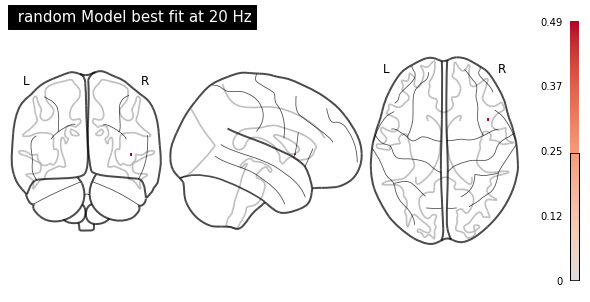

In [61]:
best_corr_random_20Hz = plot_best_kendall_location(mask_img, mean_SL_20Hz_rdm_crossnobis, 
                        group_eval_score_20Hz_random, best_kendall_corr_20Hz_random,  f' random Model best fit at 20 Hz')

best_corr_random_20Hz_img = nib.Nifti1Image(best_corr_random_20Hz, affine=affine)
nib.save(best_corr_random_20Hz_img, 'standard_smooth_BestKendall_random_20Hz.nii')  

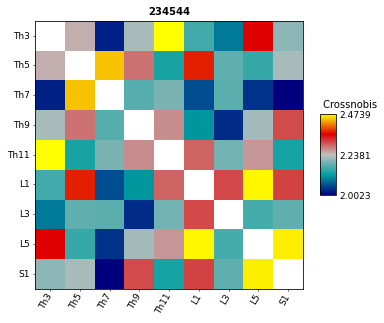

In [62]:
rsa.vis.show_rdm(mean_SL_20Hz_rdm_crossnobis[index_max_score_20Hz_random], show_colorbar = 'panel', rdm_descriptor = 'voxel_index', pattern_descriptor = 'conds', figsize=(6,6))
plt.show();
None

#### Best Group-level brain RDM at 80 Hz with random model

0.44761904761904764


/home/ubuntu/anaconda3/lib/python3.9/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


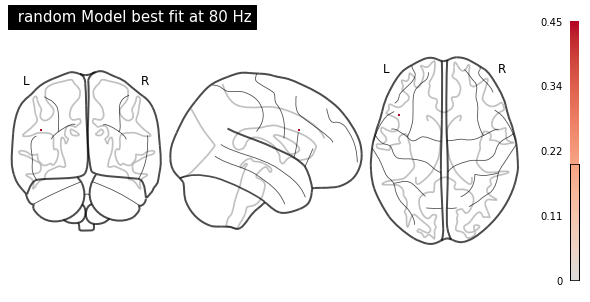

In [65]:
best_corr_random_80Hz = plot_best_kendall_location(mask_img, mean_SL_80Hz_rdm_crossnobis, 
                        group_eval_score_80Hz_random, best_kendall_corr_80Hz_random,  f' random Model best fit at 80 Hz')

best_corr_random_80Hz_img = nib.Nifti1Image(best_corr_random_80Hz, affine=affine)
nib.save(best_corr_random_80Hz_img, 'standard_smooth_BestKendall_random_80Hz.nii')

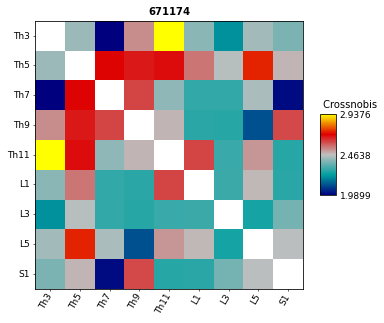

In [66]:
rsa.vis.show_rdm(mean_SL_80Hz_rdm_crossnobis[index_max_score_80Hz_random], show_colorbar = 'panel', rdm_descriptor = 'voxel_index', pattern_descriptor = 'conds', figsize=(6,6))
plt.show();
None

#### Best Group-level brain RDM at 20 Hz with simple model

0.3873015873015873


/home/ubuntu/anaconda3/lib/python3.9/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


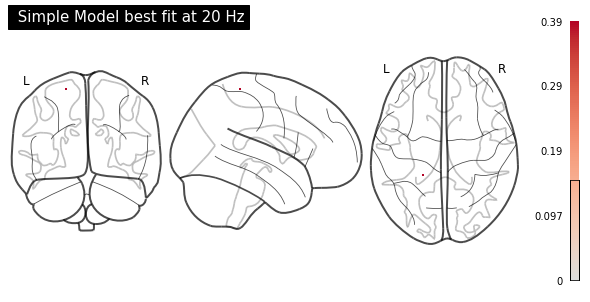

In [63]:
best_corr_simple_20Hz = plot_best_kendall_location(mask_img, mean_SL_20Hz_rdm_crossnobis, 
                        group_eval_score_20Hz_simple, best_kendall_corr_20Hz_simple,  f' Simple Model best fit at 20 Hz')

best_corr_simple_20Hz_img = nib.Nifti1Image(best_corr_simple_20Hz, affine=affine)
nib.save(best_corr_simple_20Hz_img, 'standard_smooth_BestKendall_simple_20Hz.nii')                                          

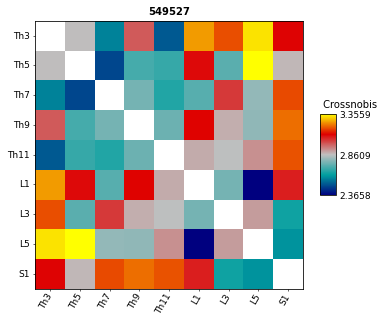

In [64]:
rsa.vis.show_rdm(mean_SL_20Hz_rdm_crossnobis[index_max_score_20Hz_simple], show_colorbar = 'panel', rdm_descriptor = 'voxel_index', pattern_descriptor = 'conds', figsize=(6,6))
plt.show();
None

#### Best Group-level brain RDM at 80 Hz with simple model

0.43492063492063493
0.43492063492063493


/home/ubuntu/anaconda3/lib/python3.9/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


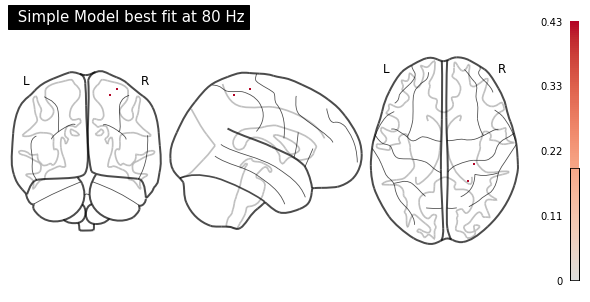

In [67]:
best_corr_simple_80Hz = plot_best_kendall_location(mask_img, mean_SL_80Hz_rdm_crossnobis, 
                        group_eval_score_80Hz_simple, best_kendall_corr_80Hz_simple,  f' Simple Model best fit at 80 Hz')

best_corr_simple_80Hz_img = nib.Nifti1Image(best_corr_simple_80Hz, affine=affine)
nib.save(best_corr_simple_80Hz_img, 'standard_smooth_BestKendall_simple_80Hz.nii') 

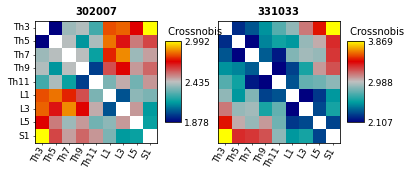

In [68]:
rsa.vis.show_rdm(mean_SL_80Hz_rdm_crossnobis[index_max_score_80Hz_simple], show_colorbar = 'panel', rdm_descriptor = 'voxel_index', pattern_descriptor = 'conds', figsize=(6,6))
None

#### Best Group-level brain RDM at 20 Hz with Segmental model

0.6634920634920635


/home/ubuntu/anaconda3/lib/python3.9/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


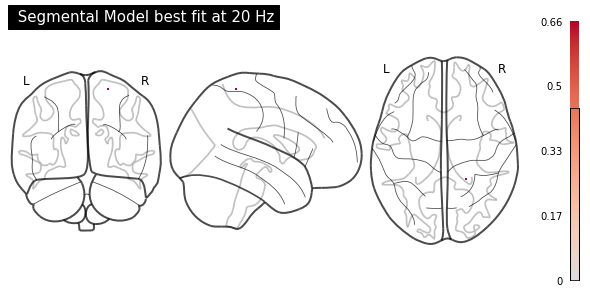

In [65]:
best_corr_linear_20Hz = plot_best_kendall_location(mask_img, mean_SL_20Hz_rdm_crossnobis, 
                        group_eval_score_20Hz_linear, best_kendall_corr_20Hz_linear,  f' Segmental Model best fit at 20 Hz')

best_corr_linear_20Hz_img = nib.Nifti1Image(best_corr_linear_20Hz, affine=affine)
nib.save(best_corr_linear_20Hz_img, 'standard_smooth_BestKendall_linear_20Hz.nii')  

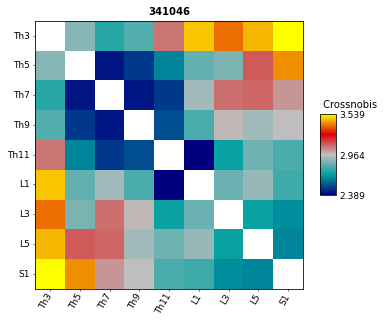

In [66]:
rsa.vis.show_rdm(mean_SL_20Hz_rdm_crossnobis[index_max_score_20Hz_linear], show_colorbar = 'panel', rdm_descriptor = 'voxel_index', pattern_descriptor = 'conds', figsize=(6,6) )
None

#### Best Group-level brain RDM at 80 Hz with segmental model

0.7841269841269841


/home/ubuntu/anaconda3/lib/python3.9/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


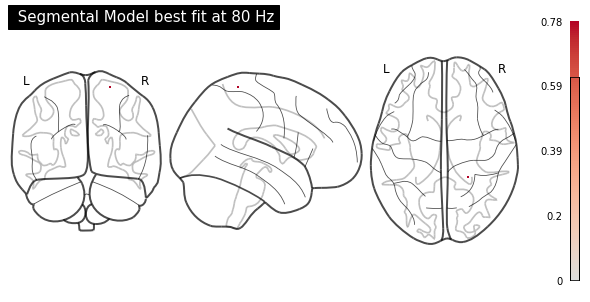

In [69]:
best_corr_linear_80Hz = plot_best_kendall_location(mask_img, mean_SL_80Hz_rdm_crossnobis, 
                        group_eval_score_80Hz_linear, best_kendall_corr_80Hz_linear,  f' Segmental Model best fit at 80 Hz')

best_corr_linear_80Hz_img = nib.Nifti1Image(best_corr_linear_80Hz, affine=affine)
nib.save(best_corr_linear_80Hz_img, 'standard_smooth_BestKendall_linear_80Hz.nii') 

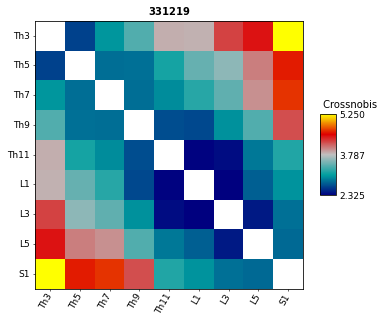

In [70]:
rsa.vis.show_rdm(mean_SL_80Hz_rdm_crossnobis[index_max_score_80Hz_linear], show_colorbar = 'panel', rdm_descriptor = 'voxel_index', pattern_descriptor = 'conds', figsize=(6,6) )
None